# Predicting the duration of a trip of bicycle rental for UrbanBike

Aim:
- Predict the capacity in the next 30-90 min for showing it to customers on UrbanBike's application

Method:
- Predict the duration of the bike trips from the time when a bike is picked up from a docking station to the time when it is
returned to a docking station

Data we have from UrbanBike: 
- Bike docking stations
- Historical trips
- Weather data

Tasks:
- Perform data exploration
- Develop and evaluate a machine learning model to predict the duration of a trip
- Prepare a short presentation (15 mins max) outlining the modelling approach, results and any further steps you would propose to the client

## Data Exploration

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from geopy.distance import distance
import numpy as np
import seaborn as sns
from scipy import stats
import swifter

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

In [10]:
path = 'data/'

In [5]:
df_station = pd.read_csv(path + 'hubway_stations.csv')
df_trips = pd.read_csv(path + 'hubway_trips.csv')
df_weather = pd.read_csv(path + 'weather.csv')

### Exploring trip data

In [4]:
df_trips.sample(5,random_state=42)

,seq_id,hubway_id,status,duration,start_date,strt_statn,end_date,end_statn,bike_nr,subsc_type,zip_code,birth_date,gender
317347,317348,360655,Closed,905,7/4/2012 14:32:00,42.0,7/4/2012 14:47:00,39.0,B00480,Registered,'02118,1985.0,Female
1004796,1004797,1134287,Closed,120,7/14/2013 22:51:00,68.0,7/14/2013 22:53:00,75.0,B01462,Registered,'02115,NaN,Male
1416853,1416854,1576387,Closed,1020,10/11/2013 15:03:00,58.0,10/11/2013 15:20:00,52.0,B00205,Casual,'02215,NaN,NaN
335686,335687,380878,Closed,350,7/12/2012 07:50:00,26.0,7/12/2012 07:56:00,50.0,B00474,Registered,'02118,1975.0,Male
330414,330415,375163,Closed,425,7/10/2012 06:48:00,38.0,7/10/2012 06:55:00,64.0,B00023,Registered,'02478,1990.0,Male


In [5]:
df_trips['status'].unique()

array(['Closed'], dtype=object)

In [4]:
df_trips = df_trips.drop(columns=['status'])

In [5]:
df_trips = df_trips.query('duration > 0')

<AxesSubplot:>

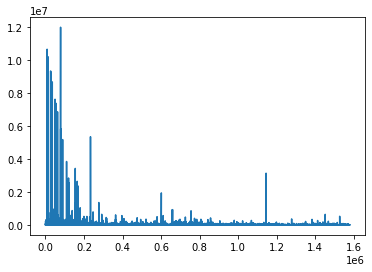

In [254]:
df_trips.duration.plot()

In [6]:
def format_trip_date(string):
    return datetime.strptime(string,'%m/%d/%Y %H:%M:%S')
df_trips['start_date'] = df_trips['start_date'].swifter.apply(format_trip_date)
df_trips['end_date'] = df_trips['end_date'].swifter.apply(format_trip_date)

In [7]:
df_trips['month_start'] = df_trips.start_date.swifter.apply(lambda x: x.month)
df_trips['day_start'] = df_trips.start_date.swifter.apply(lambda x: x.day)
df_trips['dayOfWeek_start'] = df_trips.start_date.swifter.apply(lambda x:x.weekday()+1)  # set Monday to 1
df_trips['hour_start'] = df_trips.start_date.swifter.apply(lambda x:x.hour)

In [8]:
df_trips['month_end'] = df_trips.end_date.swifter.apply(lambda x: x.month)
df_trips['day_end'] = df_trips.end_date.swifter.apply(lambda x: x.day)
df_trips['dayOfWeek_end'] = df_trips.end_date.swifter.apply(lambda x:x.weekday()+1)  # set Monday to 1
df_trips['hour_end'] = df_trips.end_date.swifter.apply(lambda x:x.hour)

<AxesSubplot:xlabel='duration'>

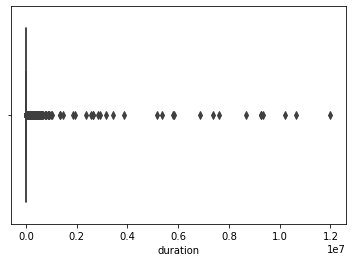

In [258]:
sns.boxplot(x=df_trips.duration)

In [9]:
z = np.abs(stats.zscore(df_trips.duration))
df_trips_cut = df_trips[(z < 3)]
df_trips_cut.shape[0]

1573820

In [146]:
df_trips.duration[(z > 3)].sort_values()

5807         80970
54918        80970
939282       81060
147522       81079
5119         81087
            ...   
28396      9260227
27081      9340553
14522     10196477
8859      10659471
78677     11994458
Name: duration, Length: 767, dtype: int64

<AxesSubplot:xlabel='duration'>

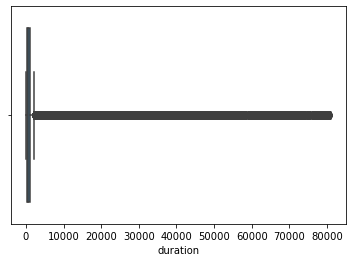

In [133]:
sns.boxplot(x=df_trips_cut.duration)

In [186]:
data_mean, data_std = np.mean(df_trips.duration), np.std(df_trips.duration)
cut_off = data_std * 3
lower, upper = data_mean - cut_off, data_mean + cut_off
print(lower, upper,data_mean, data_std)
df_trips_cut_SD = df_trips.query('@lower < duration < @upper')
df_trips_cut_SD.shape[0]

-78514.0739293213 80921.77247122467 1203.8492709516845 26572.64106675766


1573820

<AxesSubplot:xlabel='duration'>

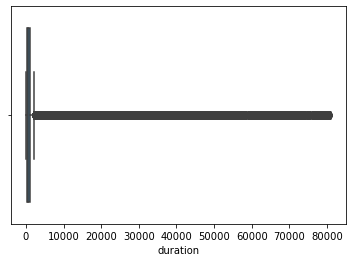

In [152]:
sns.boxplot(x=df_trips_cut_SD.duration)

In [260]:
Q1 = df_trips.duration.quantile(0.25)
Q3 = df_trips.duration.quantile(0.75)
IQR = Q3 - Q1
df_trips_cut_IQR = df_trips.query('@Q1 - 1.5*@IQR < duration < @Q3 + 1.5*@IQR')
df_trips_cut_IQR.shape[0]

1470300

<AxesSubplot:xlabel='duration'>

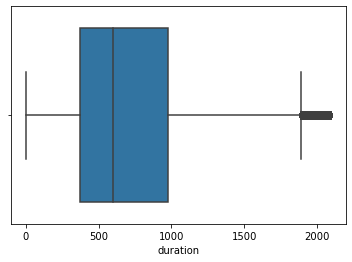

In [153]:
sns.boxplot(x=df_trips_cut_IQR.duration)

<AxesSubplot:xlabel='hour'>

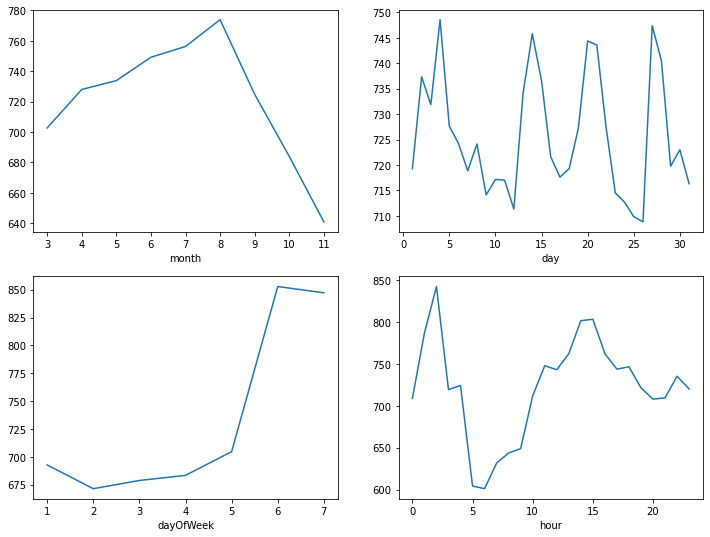

In [189]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,9))
df_trips_cut_IQR.groupby('month_start').mean()['duration'].plot(ax=axs[0][0])
df_trips_cut_IQR.groupby('day_start').mean()['duration'].plot(ax=axs[0][1])
df_trips_cut_IQR.groupby('dayOfWeek_start').mean()['duration'].plot(ax=axs[1][0])
df_trips_cut_IQR.groupby('hour_start').mean()['duration'].plot(ax=axs[1][1])

<AxesSubplot:xlabel='hour'>

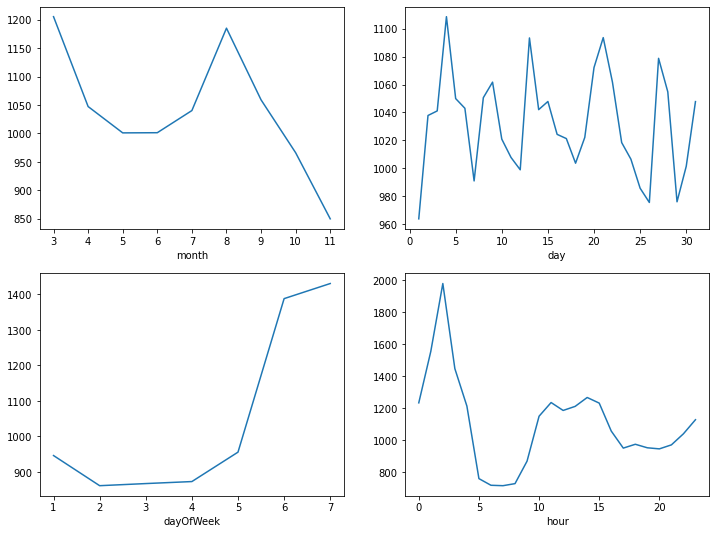

In [190]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,9))
df_trips_cut.groupby('month_start').mean()['duration'].plot(ax=axs[0][0])
df_trips_cut.groupby('day_start').mean()['duration'].plot(ax=axs[0][1])
df_trips_cut.groupby('dayOfWeek_start').mean()['duration'].plot(ax=axs[1][0])
df_trips_cut.groupby('hour_start').mean()['duration'].plot(ax=axs[1][1])

<AxesSubplot:xlabel='hour_end'>

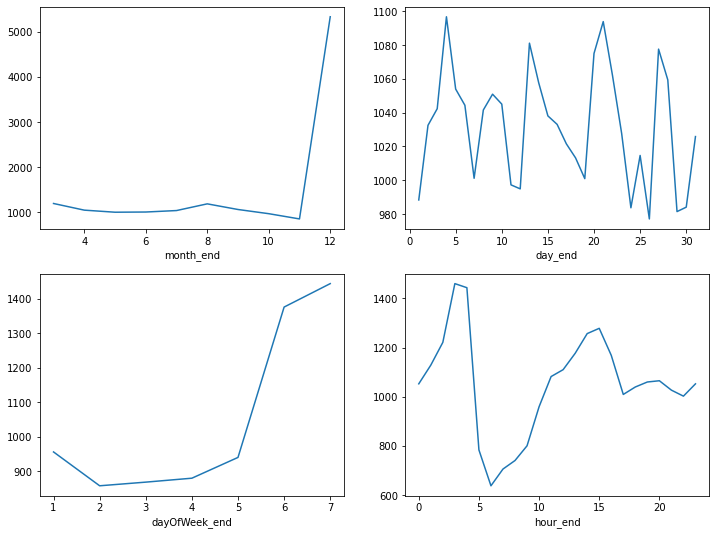

In [229]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,9))
df_trips.groupby('month_end').mean()['duration'].plot(ax=axs[0][0])
df_trips.groupby('day_end').mean()['duration'].plot(ax=axs[0][1])
df_trips.groupby('dayOfWeek_end').mean()['duration'].plot(ax=axs[1][0])
df_trips.groupby('hour_end').mean()['duration'].plot(ax=axs[1][1])

In [261]:
df_trips.start_date.min(),df_trips.start_date.max()

(Timestamp('2011-07-28 10:12:00'), Timestamp('2013-11-30 23:39:00'))

In [102]:
df_trips.value_counts('bike_nr')

bike_nr
B00490    2138
B00268    2124
B00548    2112
B00559    2091
B00563    2080
          ... 
T01129      49
B00218      35
B00137      31
B00542      28
T01064      10
Length: 1163, dtype: int64

In [10]:
df_trips = df_trips.drop(columns=['seq_id','hubway_id'])

In [266]:
df_trips.isna().sum()

duration                 0
start_date               0
strt_statn              14
end_date                 0
end_statn               45
bike_nr                466
subsc_type               0
zip_code            472712
birth_date         1223968
gender              472572
month_start              0
day_start                0
dayOfWeek_start          0
hour_start               0
month_end                0
day_end                  0
dayOfWeek_end            0
hour_end                 0
dtype: int64

In [267]:
df_trips.corr()

,duration,strt_statn,end_statn,birth_date,month_start,day_start,dayOfWeek_start,hour_start,month_end,day_end,dayOfWeek_end,hour_end
duration,1.000000,-0.004821,-0.005850,-0.002784,-0.000395,0.000197,0.007379,0.000514,0.003143,-0.002254,0.006460,-0.004913
strt_statn,-0.004821,1.000000,0.338162,0.036458,0.097581,-0.006696,0.005404,-0.016105,0.097545,-0.006609,0.005566,-0.016198
end_statn,-0.005850,0.338162,1.000000,0.030072,0.095527,-0.007348,0.003785,0.028354,0.095517,-0.007348,0.003901,0.027000
birth_date,-0.002784,0.036458,0.030072,1.000000,-0.000664,-0.003771,0.081209,0.098961,-0.000641,-0.003846,0.081202,0.090966
month_start,-0.000395,0.097581,0.095527,-0.000664,1.000000,-0.129699,-0.014000,-0.024379,0.999960,-0.129529,-0.013965,-0.025198
day_start,0.000197,-0.006696,-0.007348,-0.003771,-0.129699,1.000000,-0.002646,-0.001968,-0.129522,0.998691,-0.002407,-0.002288
dayOfWeek_start,0.007379,0.005404,0.003785,0.081209,-0.014000,-0.002646,1.000000,0.005974,-0.013966,-0.002789,0.996470,0.011783
hour_start,0.000514,-0.016105,0.028354,0.098961,-0.024379,-0.001968,0.005974,1.000000,-0.024231,-0.002202,0.006938,0.950514
month_end,0.003143,0.097545,0.095517,-0.000641,0.999960,-0.129522,-0.013966,-0.024231,1.000000,-0.129714,-0.013925,-0.025459
day_end,-0.002254,-0.006609,-0.007348,-0.003846,-0.129529,0.998691,-0.002789,-0.002202,-0.129714,1.000000,-0.002555,-0.001926


### Exploring station data

In [20]:
df_station.sample(10, random_state=42)

,id,terminal,station,municipal,lat,lng,status
131,135,M32026,359 Broadway - Broadway at Fayette Street,Cambridge,42.370803,-71.104412,Existing
19,22,A32010,South Station - 700 Atlantic Ave.,Boston,42.352175,-71.055547,Existing
81,85,C32012,Andrew Station - Dorchester Ave at Humboldt Pl,Boston,42.330825,-71.057007,Removed
96,100,B32017,Dudley Square,Boston,42.328654,-71.084198,Existing
56,60,D32016,Charles Circle - Charles St. at Cambridge St.,Boston,42.360877,-71.071310,Removed
12,15,A32005,Harvard Real Estate - Brighton Mills - 370 Wes...,Boston,42.361667,-71.138020,Existing
98,102,C32002,Boston Medical Center - East Concord at Harri...,Boston,42.336437,-71.073089,Existing
65,69,K32001,Coolidge Corner - Beacon St @ Centre St,Brookline,42.341598,-71.123338,Existing
66,70,M32016,Harvard Kennedy School at Bennett St / Eliot St,Cambridge,42.372244,-71.121851,Existing
18,21,C32007,Prudential Center / Belvidere,Boston,42.345959,-71.082578,Existing


terminal (name), station (name) are not useful, so can be dropped

In [11]:
df_station = df_station.drop(columns=['terminal','station'])


In [30]:
df_station.shape

(142, 7)

In [38]:
df_station['municipal'].unique()

array(['Boston', 'Cambridge', 'Brookline', 'Somerville'], dtype=object)

In [12]:
df_station['color'] = df_station['status'].swifter.apply(lambda x: 'Black' if x == 'Existing' else 'Grey')

Pandas Apply: 100%|██████████| 142/142 [00:00<?, ?it/s]


<AxesSubplot:xlabel='lng', ylabel='lat'>

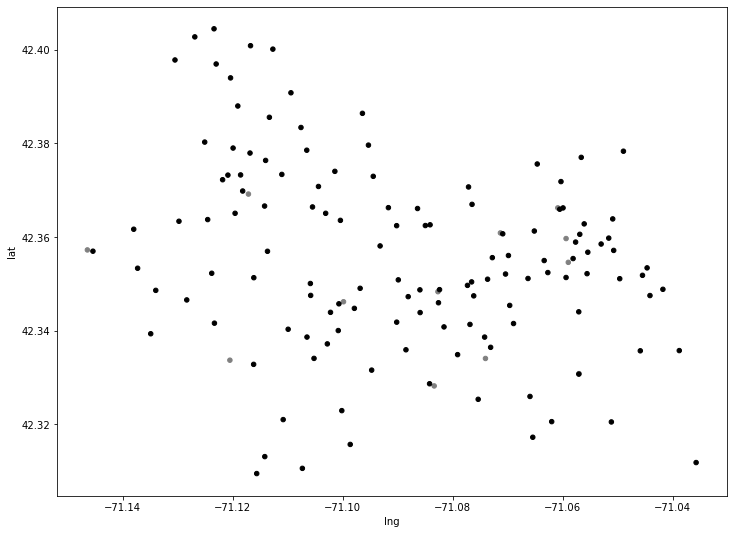

In [46]:
fig, ax = plt.subplots(figsize=(12,9))
df_station.plot(x="lng", y="lat", kind="scatter", c="color",ax=ax)

In [ ]:
df_station = df_station.drop(columns=['color'])

### Exploring weather data

In [6]:
df_weather.sample(10,random_state=42)

,STATION,STATION_NAME,ELEVATION,LATITUDE,LONGITUDE,DATE,HPCP,Measurement_Flag,Quality_Flag
831,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20120402 00:00,0.05,,
124,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20110828 08:00,0.14,,
1429,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20121009 07:00,0.00,T,
1610,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20121127 21:00,0.00,T,
700,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20120224 11:00,0.01,,
649,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20120130 09:00,0.00,T,
1898,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20130131 02:00,0.00,T,
765,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20120309 05:00,0.00,T,
173,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20110907 18:00,0.01,,
461,COOP:190770,BOSTON MA US,3.7,42.3606,-71.0106,20111206 21:00,0.01,,


In [10]:
df_weather.STATION.unique()

array(['COOP:190770'], dtype=object)

In [14]:
df_weather['Measurement_Flag'].unique()

array(['T', ' ', 'g'], dtype=object)

In [16]:
df_weather['Quality_Flag'].unique()

array([' '], dtype=object)

There is only one weather station, Quality_Flag Can be drop as it is null, so only DATE, HPCP(Hourly Precipitation) are useful.

In [13]:
df_weather = df_weather[['DATE', 'HPCP','Measurement_Flag']]

In [14]:
df_weather['DATE'] = df_weather['DATE'].swifter.apply(lambda x:datetime.strptime(x,'%Y%m%d %H:%M'))

Pandas Apply: 100%|██████████| 2654/2654 [00:00<00:00, 110558.40it/s]


<AxesSubplot:xlabel='DATE'>

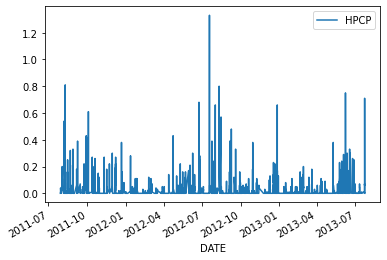

In [272]:
df_weather.plot(x='DATE',y='HPCP')

## Data Cleaning

### Merging dataframes

In [15]:
df_trips_cut.shape[0]

1573820

In [16]:
df = df_trips_cut.merge(df_station, left_on= 'strt_statn',right_on='id',suffixes=('','_strt'))
df = df.merge(df_station, left_on= 'end_statn',right_on='id',suffixes=('','_end'))
df = df.rename(columns={'lat':'lat_strt','lng':'lng_strt'})
df = df.drop(columns=['id','id_end'])
df.shape[0]

1573783

<AxesSubplot:>

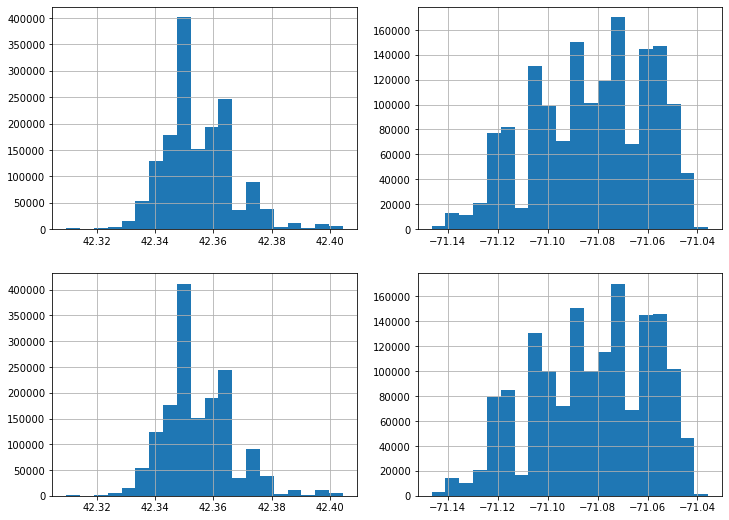

In [17]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,9))
df['lat_strt'].hist(bins=20,ax=axs[0][0])
df['lng_strt'].hist(bins=20,ax=axs[0][1])
df['lat_end'].hist(bins=20,ax=axs[1][0])
df['lng_end'].hist(bins=20,ax=axs[1][1])

In [18]:
def hour_rounder(t):
    return t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
df['start_date_h'] = df['start_date'].swifter.apply(hour_rounder)
df['end_date_h'] = df['end_date'].swifter.apply(hour_rounder)

Dask Apply: 100%|██████████| 32/32 [00:03<00:00, 10.43it/s]


In [19]:
df_weather['rain'] = df_weather.swifter.apply(lambda x: bool(x.HPCP > 0 or x.Measurement_Flag=="T"),axis=1)

Pandas Apply: 100%|██████████| 2654/2654 [00:00<00:00, 63175.69it/s]


In [20]:
df_weather_rain = df_weather[['DATE','rain']]

In [21]:
df = df.merge(df_weather_rain, left_on= 'start_date_h',right_on='DATE',suffixes=('','_start_date'),how='outer')
df = df.merge(df_weather_rain, left_on= 'end_date_h',right_on='DATE',suffixes=('','_end_date'),how='outer')
df = df.drop(columns=['DATE','DATE_end_date'])

In [23]:
df['rain'] = df[['rain','rain_end_date']].swifter.apply(lambda x: x.rain or x.rain_end_date, axis=1)
df = df.drop(columns=['rain_end_date'])
df.rain = df.rain.fillna(False)

Dask Apply: 100%|██████████| 32/32 [00:04<00:00,  7.39it/s]


In [29]:
df_weather = df_weather.set_index('DATE')

In [ ]:
# df['rain_duration'] = df.swifter.apply(lambda r: df_weather.loc[r.start_date:r.end_date].rain.any(), axis=1)
# df['PP'] = df.swifter.swifter.apply(lambda r: df_weather.loc[r.start_date:r.end_date].HPCP.sum(), axis=1)

In [34]:
df = df.dropna(subset=['lat_strt','lng_strt','lat_end','lng_end'])

In [35]:
def get_distance(x):
    return distance((x['lat_strt'],x['lng_strt']),(x['lat_end'],x['lng_end'])).km
df['statn_dist'] = df[['lat_strt','lng_strt','lat_end','lng_end']].swifter.apply(get_distance, axis=1)

Dask Apply: 100%|██████████| 32/32 [00:53<00:00,  1.67s/it]
C:\Users\david\AppData\Local\Temp/ipykernel_24484/1337660284.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['statn_dist'] = df[['lat_strt','lng_strt','lat_end','lng_end']].swifter.apply(get_distance, axis=1)


In [36]:
df.to_csv('data.csv',index=False)

## Modelling

In [2]:
df= pd.read_csv('data.csv')

C:\Users\david\anaconda3\envs\DSTest\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (30) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
df.columns

Index(['Unnamed: 0', 'duration', 'start_date', 'strt_statn', 'end_date',
       'end_statn', 'bike_nr', 'subsc_type', 'zip_code', 'birth_date',
       'gender', 'month_start', 'day_start', 'dayOfWeek_start', 'hour_start',
       'month_end', 'day_end', 'dayOfWeek_end', 'hour_end', 'municipal',
       'lat_strt', 'lng_strt', 'status', 'municipal_end', 'lat_end', 'lng_end',
       'status_end', 'start_date_h', 'end_date_h', 'statn_dist',
       'rain_duration', 'pp', 'rain'],
      dtype='object')

In [6]:
df_ = df.drop(columns=['Unnamed: 0','start_date','end_date','start_date_h', 'end_date_h','rain_duration', 'pp'])

In [7]:
df_ = df_.dropna(subset=['bike_nr'])

In [8]:
cat_features = ['municipal', 'municipal_end',
'strt_statn', 'end_statn','bike_nr',
'subsc_type', 'rain','status','status_end'],
num_features = ['month_start', 'day_start', 'dayOfWeek_start', 'hour_start',
'month_end', 'day_end', 'dayOfWeek_end', 'hour_end',
'lat_strt', 'lng_strt', 'lat_end', 'lng_end',
'statn_dist']
mem_features = ['zip_code', 'birth_date', 'gender']

In [9]:
df_s = df_.drop(columns=['zip_code', 'birth_date', 'gender','bike_nr'])

In [10]:
c = ['rain','status','status_end','municipal', 'municipal_end','subsc_type','strt_statn', 'end_statn']
df_s = pd.get_dummies(df_s, columns=c, prefix=c)

In [10]:
X = df_[['month_start', 'day_start', 'dayOfWeek_start', 'hour_start', 'month_end', 'day_end', 'dayOfWeek_end', 'hour_end',
        'lat_strt', 'lng_strt', 'status', 'status_end', 'lat_end', 'lng_end', 'statn_dist', 'rain']]
y = df_['duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 727.4845148249086
Mean Squared Error: 1526549.350466416
Root Mean Squared Error: 1235.536057938584


In [11]:
X = df_s.drop(columns= 'duration')
y = df_s['duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
reg = LinearRegression().fit(X_train, y_train)
print(reg.score(X_test,y_test))
y_pred = reg.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

0.6936047055583292
Mean Absolute Error: 733.3725095867605
Mean Squared Error: 1522659.1850252734
Root Mean Squared Error: 1233.9607712667666


In [13]:
rf = RandomForestRegressor(random_state=42,n_jobs=-1)
rf.fit(X_train, y_train)

Below are not finished

In [14]:
features_s = ['municipal', 'strt_statn','bike_nr','subsc_type', 'rain','status',
'month_start', 'day_start', 'dayOfWeek_start', 'hour_start',
'lat_strt', 'lng_strt']

In [16]:
X = df_s[features_s]
y = df_s['duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
reg = LinearRegression().fit(X_train, y_train)
print(reg.score(X_test,y_test))
y_pred = reg.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

KeyError: "['municipal', 'strt_statn', 'bike_nr', 'subsc_type', 'rain', 'status'] not in index"